<a href="https://colab.research.google.com/github/howhzh/30min_guides/blob/master/Shap_advanced_uses_grouping_and_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dft-accident-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F759%2F1572%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T170505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D91c4861a82583c6097447f17aaaf6df61f7d1d7cb8c6dfb0e3e5e6d52519c1bf2f2e5280834eb0c70b0a8c820fbbf80d2fe278fcf325ec1785426dda1395aea4436959b55d6c546e50894fbe0af446a3379a569e428dae972332383b1fb3dfc45d582726c36a3e0e8392b48781a7442f24aeaef41f77f75e3c922bfa528235f9e8fca6001a6d1f63fd2f370f1407fc376b67810556f975ab659638b5782dd7cdfdb2a3cc01d2a99dea50729b36a45094d81feb82efc70a08989d059275cb56f639eebfd14a966018201ece9f20fd2ae4d5383363e05895af57d6b5ce32e020f9ea797af29da56ecac5b35b58986678535c7e7638298752ced8a06d1a2a8bc85c,weather-dataset-rattle-package:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F6012%2F1733506%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240507%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240507T170505Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da1475700ef8562e00265d9528555600e9d5fac6da61ac7437e1576f7761c876f41b8659738d5f19d785f17b85f956d8288480381334b4581efbac8692ef9767f13a82e74df25024b8b5e91073a0a6672a6b10138d2e0d926efc648815e2d0625ca7d142b947b62c69a254782e1c1b97b10ad646d491cb3e8878e00720b8293f046d51f45a286699eca9aaffb15f05b9cb72517a3684e2ad8817e0bc39552ca354dacf65586df94b4a8549c3c00f0e1da7573f98256d256b79b63703b044097749a926f2bf68aa53b9612f8d64c54ad12c1414ec66554e2f6a075e6fe9209fdfcb1376602c5d00dfe03ba378c42e050168158737ac92085827ec030b6e94d0098'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 116925260 bytes downloaded
Downloaded and uncompressed: dft-accident-data
[==================================================] 4020790 bytes downloaded
Downloaded and uncompressed: weather-dataset-rattle-package
Data source import complete.


In [5]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.9 MB/s eta 0:00:00


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

%matplotlib inline
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dft-accident-data/Accidents0515.csv
/kaggle/input/dft-accident-data/Casualties0515.csv
/kaggle/input/dft-accident-data/Vehicles0515.csv
/kaggle/input/dft-accident-data/tidydata.sh
/kaggle/input/dft-accident-data/contextCSVs/Age_Band.csv
/kaggle/input/dft-accident-data/contextCSVs/Police_Officer_Attend.csv
/kaggle/input/dft-accident-data/contextCSVs/Ped_Movement.csv
/kaggle/input/dft-accident-data/contextCSVs/Point_of_Impact.csv
/kaggle/input/dft-accident-data/contextCSVs/Casualty_Type.csv
/kaggle/input/dft-accident-data/contextCSVs/Vehicle_Manoeuvre.csv
/kaggle/input/dft-accident-data/contextCSVs/Police_Force.csv
/kaggle/input/dft-accident-data/contextCSVs/Vehicle_Type.csv
/kaggle/input/dft-accident-data/contextCSVs/Urban_Rural.csv
/kaggle/input/dft-accident-data/contextCSVs/Junction_Location.csv
/kaggle/input/dft-accident-data/contextCSVs/Junction_Control.csv
/kaggle/input/dft-accident-data/contextCSVs/Road_Class.csv
/kaggle/input/dft-accident-data/contextCSVs/Ped_Cross_

In [7]:
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

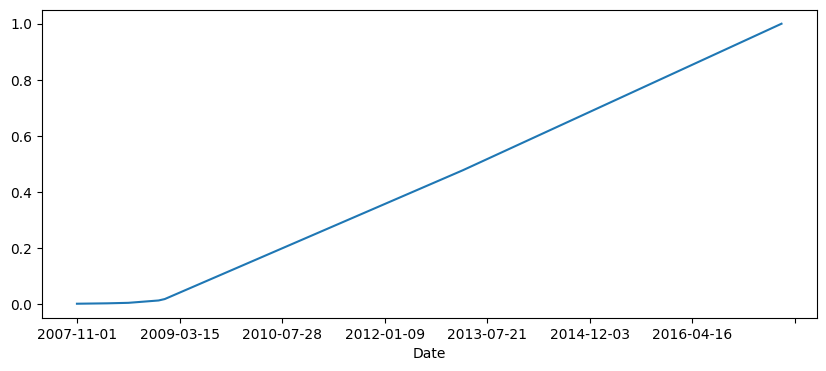

In [8]:
data=pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
plt.figure(figsize=(10,4))
data.Date.value_counts(True).sort_index().cumsum().plot();

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [10]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [11]:
features = data.drop(['Date', 'RainTomorrow'], axis = 1).columns.tolist()
cat_features = data[features].select_dtypes('object').columns.tolist()

In [12]:
data['target']= (data['RainTomorrow']=='Yes').astype(int)

In [15]:
data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
target               0
dtype: int64

In [21]:
data = data.dropna(subset = ['RainTomorrow'])

In [29]:
data2 = data.fillna(-99)

# SHAP - Feature Contribution and Importance

In [30]:
train = data2.loc[data['Date']< '2015-01-01']
test = data2.query("Date>= '2015-01-01'")
train.shape, test.shape

((98988, 24), (43205, 24))

In [31]:
clf = CatBoostClassifier(iterations = 30)
clf.fit(train[features],train['target'], cat_features=cat_features, verbose=False)

In [32]:
train_auc = roc_auc_score(train['target'], clf.predict_proba(train[features])[:,1])
test_auc = roc_auc_score(test['target'], clf.predict_proba(test[features])[:,1] )
print("Train AUC: ", train_auc)
print("Out-of-time AUC: ", test_auc)

Train AUC:  0.8890103431335361
Out-of-time AUC:  0.8695143051253601


## Basic SHAP plot

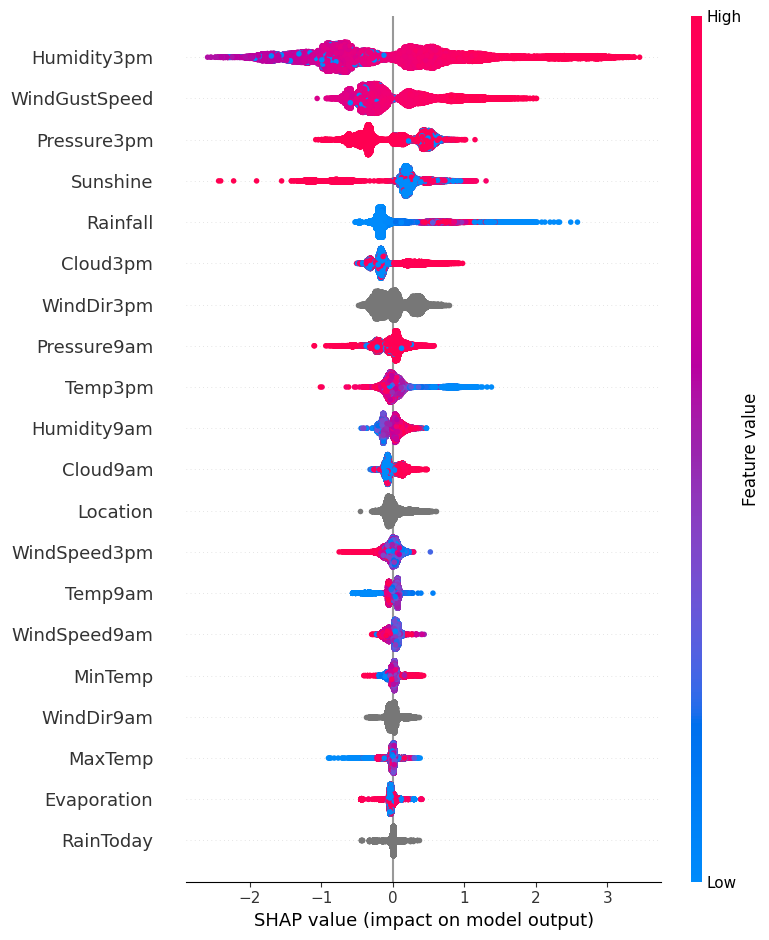

In [33]:
from shap import TreeExplainer
exp = TreeExplainer(clf)

shap_vals = exp.shap_values(test[features])
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features'))
shap.summary_plot(shap_vals, test[features])

In [43]:
shap_vals.shape, test[features].shape

((43205, 21), (43205, 21))

In [105]:
shap_df.abs().describe()

features,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
count,9.898800e+04,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.0,98988.000000,98988.000000,9.898800e+04,...,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,98988.000000,9.898800e+04,9.898800e+04,98988.000000
mean,7.536534e-02,0.044793,0.037684,0.243673,0.034195,0.420469,0.0,0.421200,0.049416,1.808422e-01,...,0.072407,0.096962,0.864055,0.133207,0.395077,0.099385,0.221373,6.891516e-02,7.766863e-02,0.012752
std,7.057286e-02,0.044843,0.059259,0.236661,0.027345,0.298484,0.0,0.298946,0.048387,1.273940e-01,...,0.066996,0.060801,0.614475,0.110592,0.175182,0.061831,0.111765,7.946970e-02,8.518308e-02,0.025381
min,3.019824e-07,0.000003,0.000001,0.000021,0.000143,0.000006,0.0,0.000214,0.000008,6.521607e-08,...,0.000003,0.000001,0.000004,0.000001,0.000007,0.000002,0.000102,1.099194e-07,4.135050e-07,0.000004
25%,2.704764e-02,0.016228,0.009499,0.136961,0.020438,0.187901,0.0,0.215528,0.019142,6.470293e-02,...,0.024168,0.048145,0.432311,0.049815,0.307509,0.055887,0.141366,3.110632e-02,2.754753e-02,0.002248
50%,5.883424e-02,0.031332,0.017903,0.172764,0.029239,0.284009,0.0,0.340709,0.037731,1.677556e-01,...,0.053488,0.092276,0.722316,0.099818,0.414683,0.086352,0.182741,5.249306e-02,5.938932e-02,0.003403
75%,9.540186e-02,0.057467,0.032649,0.216481,0.041225,0.613269,0.0,0.542567,0.060788,2.791560e-01,...,0.103074,0.136258,1.121186,0.198675,0.517917,0.134229,0.291711,7.097539e-02,1.045239e-01,0.015959
max,6.510484e-01,0.434771,0.908777,2.539768,0.450925,2.395239,0.0,2.125932,0.423812,7.758436e-01,...,0.773085,0.472933,3.516878,0.945860,1.167827,0.509509,0.950948,5.576688e-01,1.351100e+00,0.444923


In [44]:
shap_df.head()

features,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,-0.068444,0.006162,-0.114491,-0.157686,-0.020438,0.161293,0.0,-0.430781,-0.047333,-0.254630,...,0.037599,-0.173053,-1.799142,0.012045,0.427257,-0.078839,-0.168747,-0.060462,-0.168973,0.001656
1,-0.030312,0.043311,-0.127575,-0.190258,-0.032010,0.200674,0.0,1.048466,-0.005447,0.025213,...,0.202439,-0.213928,-1.927750,-0.019022,0.110386,-0.079475,-0.192401,-0.060383,-0.055121,0.002412
2,-0.049474,0.025662,-0.207040,-0.169438,-0.035872,0.153639,0.0,0.536131,-0.024151,0.395629,...,0.015142,-0.193606,-1.577375,-0.068748,0.070568,-0.060702,-0.175534,-0.047719,-0.029361,0.001656
3,-0.071376,0.124849,-0.012805,-0.170284,-0.032010,0.185818,0.0,-0.184374,-0.040788,-0.330063,...,0.128771,-0.170096,-0.726590,-0.065004,0.170005,0.050055,0.197458,-0.047495,-0.049218,0.002248
4,-0.018309,0.014632,-0.018711,-0.162176,-0.032010,0.158215,0.0,-0.343277,-0.047333,-0.195898,...,0.062723,-0.126140,-0.762308,0.019186,0.012207,0.075724,-0.349644,-0.047699,-0.057326,0.002041


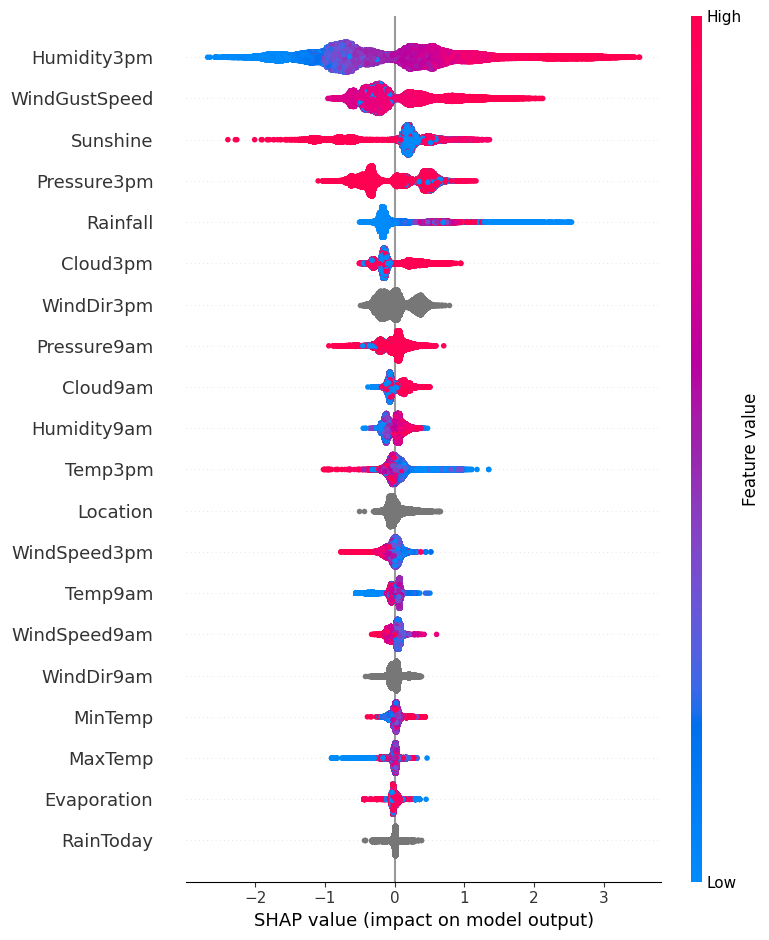

In [46]:
shap_vals = exp.shap_values(train[features])
shap_df = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features'))
shap.summary_plot(shap_vals, train[features])

## SHAP by Groups
Create group columns and sum up Shap values
Needs to transpose and aggregate by the new group column

In [47]:

groups_by_time = {
    '3pm': [f for f in features if '3pm' in f],
    '9am': [f for f in features if '9am' in f],
    'not_time_based': [f for f in features if '9am' not in f and '3pm' not in f]
}

groups_by_type = {
    'humidity_and_rain': ['Rainfall',
                          'Evaporation',
                          'Humidity9am',
                          'Humidity3pm',
                          'RainToday'],
    'temperature': ['MinTemp',
                    'MaxTemp',
                    'Temp9am',
                    'Temp3pm'],
    'sun_and_clouds': ['Cloud9am',
                       'Cloud3pm',
                       'Sunshine'],
    'wind_and_pressure': ['WindGustDir',
                          'WindGustSpeed',
                          'WindDir9am',
                          'WindDir3pm',
                          'WindSpeed9am',
                          'WindSpeed3pm',
                          'Pressure9am',
                          'Pressure3pm'],
    'location': ['Location']
}


maptime = revert_dict(groups_by_time)
maptype = revert_dict(groups_by_type)

In [48]:
maptime

{'WindDir3pm': '3pm',
 'WindSpeed3pm': '3pm',
 'Humidity3pm': '3pm',
 'Pressure3pm': '3pm',
 'Cloud3pm': '3pm',
 'Temp3pm': '3pm',
 'WindDir9am': '9am',
 'WindSpeed9am': '9am',
 'Humidity9am': '9am',
 'Pressure9am': '9am',
 'Cloud9am': '9am',
 'Temp9am': '9am',
 'Location': 'not_time_based',
 'MinTemp': 'not_time_based',
 'MaxTemp': 'not_time_based',
 'Rainfall': 'not_time_based',
 'Evaporation': 'not_time_based',
 'Sunshine': 'not_time_based',
 'WindGustDir': 'not_time_based',
 'WindGustSpeed': 'not_time_based',
 'RainToday': 'not_time_based'}

In [49]:
type(revert_dict)

function

In [50]:
shap_time = grouped_shap(shap_vals, features, groups_by_time)
shap_type = grouped_shap(shap_vals, features, groups_by_type)

In [53]:
shap_time.shape, shap_time.head()

((98988, 3),
 group       3pm       9am  not_time_based
 0     -0.709558  0.256819        0.072050
 1     -1.285507 -0.170557        0.037614
 2     -1.127305 -0.269193       -0.013132
 3     -1.589193 -0.094509       -0.648012
 4      0.565396  0.386055       -0.097172)

Step by Step

In [55]:
shap_Tdf = shap_df.T
shap_Tdf['group'] = shap_Tdf.reset_index().features.map(maptime).values
shap_Tdf.head()

,0,1,2,3,4,5,6,7,8,9,...,98979,98980,98981,98982,98983,98984,98985,98986,98987,group
features,,,,,,,,,,,,,,,,,,,,,
Location,-0.063750,-0.084720,-0.071083,-0.042917,-0.062290,-0.064490,-0.054168,-0.059031,-0.071173,-0.020770,...,-0.081772,0.008542,-0.170223,-0.170223,-0.170223,-0.166450,-0.159543,-0.028041,-0.021447,not_time_based
MinTemp,0.021511,0.023374,0.023356,0.006162,-0.020158,0.016438,0.031995,0.023374,0.019100,0.006162,...,0.232315,-0.018701,-0.016941,-0.016941,-0.016941,0.024115,0.016141,-0.016941,0.022971,not_time_based
MaxTemp,0.068216,-0.024159,0.003484,-0.005661,0.012288,-0.015824,-0.031823,0.007423,0.123010,0.000671,...,0.022374,0.006814,-0.015824,-0.193956,-0.193956,-0.015824,-0.008620,-0.186604,0.071472,not_time_based
Rainfall,-0.139505,-0.174360,-0.210693,-0.156850,-0.064497,-0.103437,-0.216632,-0.151082,-0.167861,0.119307,...,-0.066686,0.158135,-0.192521,-0.185715,-0.192521,-0.158295,-0.160898,-0.185792,-0.190230,not_time_based
Evaporation,-0.036448,-0.032010,-0.032010,-0.020438,-0.036448,-0.053181,-0.032010,-0.032010,-0.039910,-0.041609,...,-0.053181,-0.053181,-0.032010,-0.032010,-0.032010,-0.032010,-0.032010,-0.032010,-0.036048,not_time_based


In [56]:
shap_Tgrouped = shap_Tdf.groupby('group').sum()
shap_Tgrouped.head()

,0,1,2,3,4,5,6,7,8,9,...,98978,98979,98980,98981,98982,98983,98984,98985,98986,98987
group,,,,,,,,,,,,,,,,,,,,,
3pm,-0.709558,-1.285507,-1.127305,-1.589193,0.565396,-1.563648,-1.504320,-1.227951,-1.214940,-1.020634,...,-0.795726,0.144560,-0.706089,-2.082447,-1.811131,-2.249574,-2.046672,-1.966562,-1.666725,-1.334424
9am,0.256819,-0.170557,-0.269193,-0.094509,0.386055,0.081612,-0.148987,-0.087875,0.156751,-0.001176,...,-0.383691,-0.102223,-0.130485,-0.162987,-0.597694,-0.590409,-0.172352,-0.319706,-0.526962,-0.227430
not_time_based,0.072050,0.037614,-0.013132,-0.648012,-0.097172,0.755086,0.081406,-0.323206,1.478741,-0.141955,...,1.544449,0.437947,0.063997,-0.210470,-0.362374,-0.369180,-0.491638,-0.498386,-0.096943,1.526943


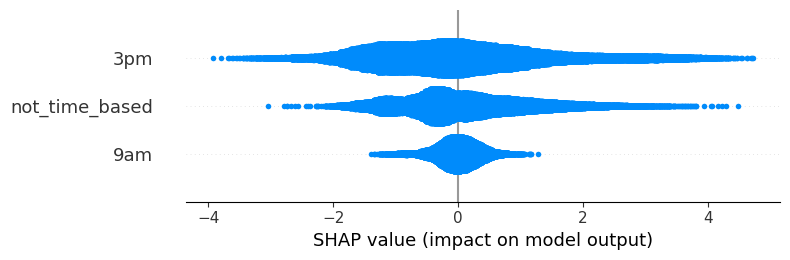

In [57]:
shap.summary_plot(shap_time.values, features=shap_time.columns)

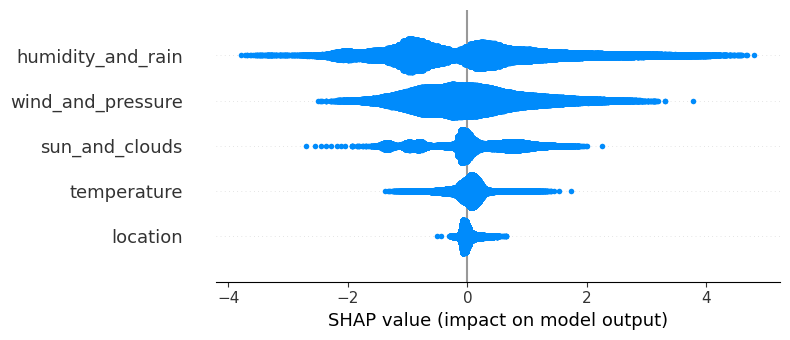

In [58]:
shap.summary_plot(shap_type.values, features=shap_type.columns)

## SHAP by score quantiles

In [59]:
preds = pd.Series(clf.predict_proba(train[features])[:,1])

In [67]:
quintiles = pd.qcut(preds, np.linspace(0,1,4), labels=np.arange(3))

In [65]:
np.linspace(0,1,6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [68]:
quintiles.value_counts().sort_index()

0    32996
1    32996
2    32996
Name: count, dtype: int64

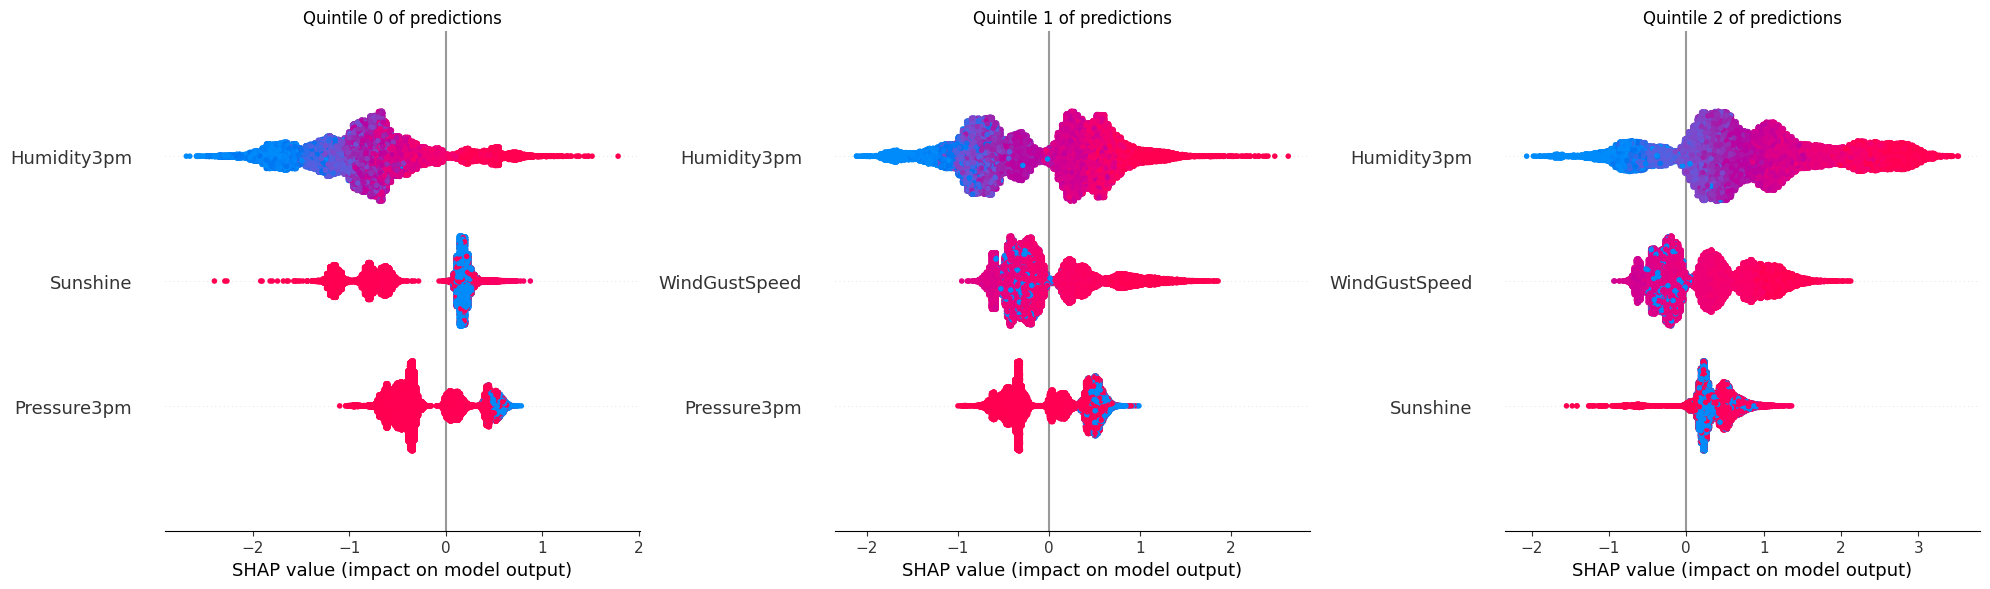

In [72]:
fig, ax = plt.subplots(1,3, figsize=(20, 6))
for q in range(3):
    plt.sca(ax[q])
    shap.summary_plot(shap_vals[(quintiles==q).values],
                      train.loc[(quintiles==q).values, features],
                      show=False,
                      plot_size=None,
                      color_bar=False,
                      max_display=3)
    plt.title(f"Quintile {q} of predictions")

In [ ]:
biens = np.arange(3)*2+2009
year = train.Date.apply(lambda s: s.split('-')[0]).astype(int)
fig, ax = plt.subplots(1,3, figsize=(36, 10))
for i, b in enumerate(biens):
    plt.sca(ax[i])
    idx = (year==b).values
    shap.summary_plot(shap_vals[idx],
                      train.loc[idx, features],
                      show=False,
                      plot_size=None,
                      color_bar=False)
    plt.title(f"Year {b}")

<Axes: ylabel='Frequency'>

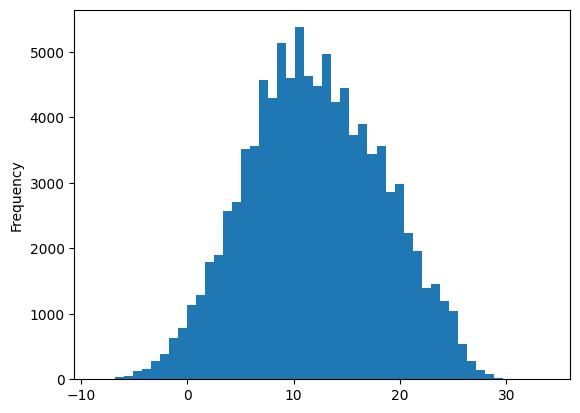

In [79]:
train.query("MinTemp > -99")['MinTemp'].plot.hist(bins=50)

In [98]:

rained_flag = (train['MinTemp'] > 25).values
rained_shap = shap_df[rained_flag]
rained_feats = train.loc[rained_flag, features]
rained_shap.shape, rained_feats.shape

((1482, 21), (1482, 21))

Text(0.5, 1.0, 'Shap for hot days (minTemp > 25 Celsius) ')

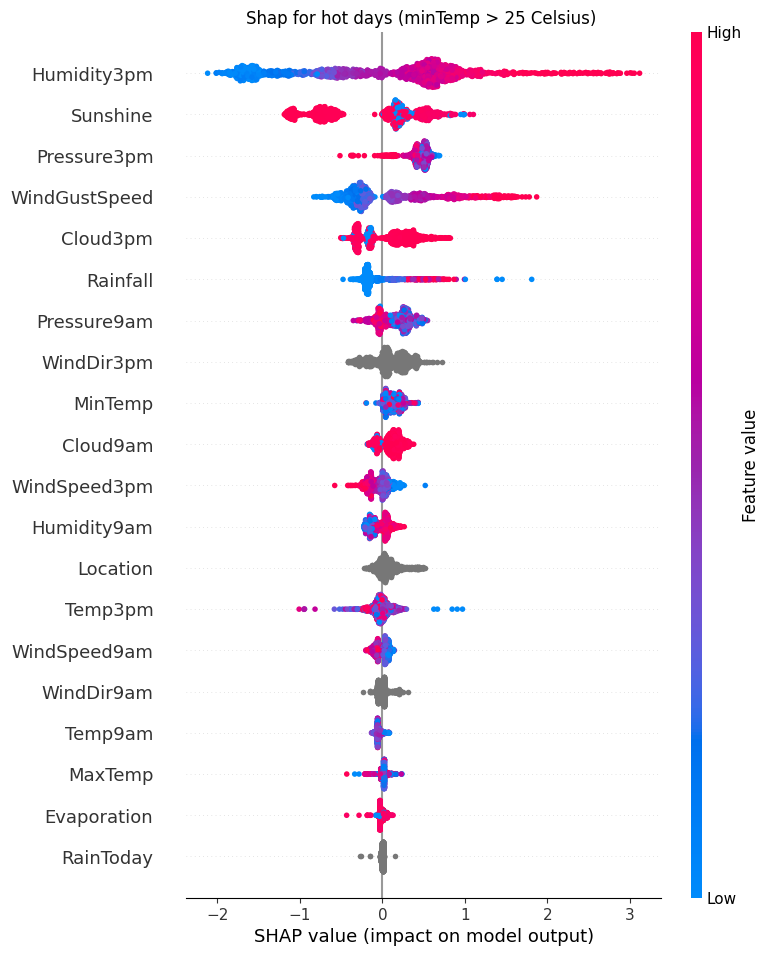

In [99]:


shap.summary_plot(rained_shap.values, rained_feats, show=False)
plt.title("Shap for hot days (minTemp > 25 Celsius) ")

# SHAP Correlations
Sorted byt feature importance


*   difficult to analyze correlations when the features have completely different distributions, or worse to compare categorical and numerical features
*   shap correlation analysis has the very useful property of being undisturbed by such differences. Whether the feature is categorical, ordinal or continuous, its shap value is continuous
*   You can
 *   get some insights about the distribution of the features themselves from the shap correlation plot, but you also
 *   understand how their impact is related in the model.
*   You can use this inspection to drive further analysis such as dependency plots between specific pairs of variables with unexpected dependencies.
*   absolute value of the spearman correlation: gives a better visualization overall if the variables are related (instead of the correlation itself)
*   help you with feature selection, since you can understand better relationships between variables, which can be synergistic or redundant. If variables are redundant, they may be splitting the importance between them, and removing one of them will increase a lot the importance of the other.



<Axes: xlabel='features', ylabel='features'>

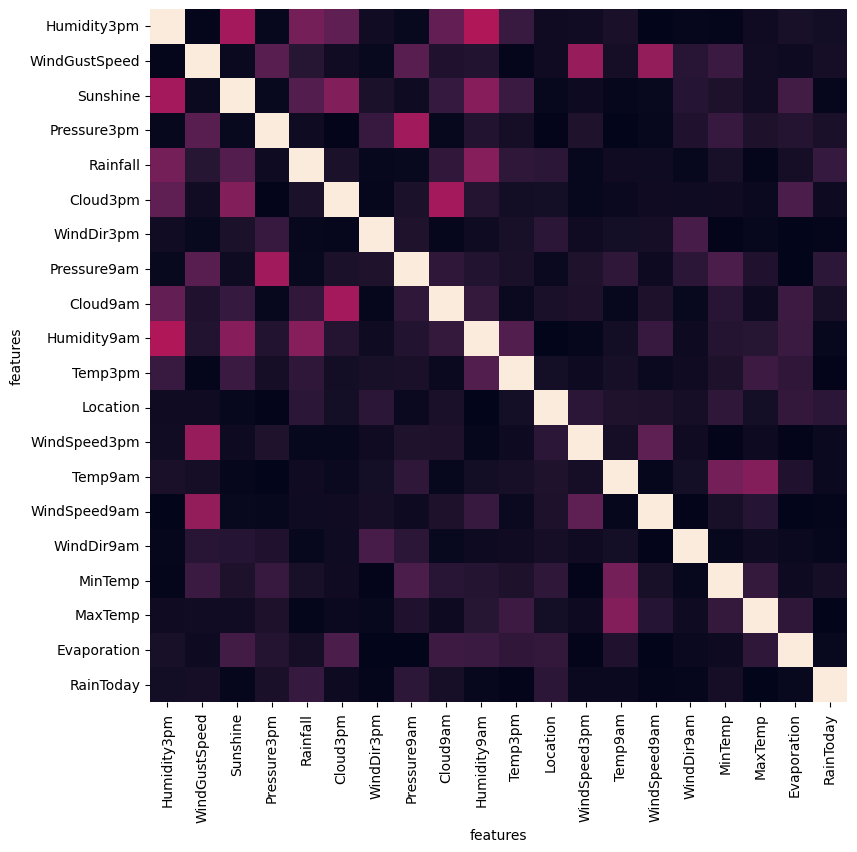

In [100]:
plt.figure(figsize=(9,9))
feat_order = shap_df.abs().mean().sort_values().index.drop("WindGustDir").tolist()[::-1]
sns.heatmap(shap_df.corr().abs().loc[feat_order, feat_order], cbar=False)

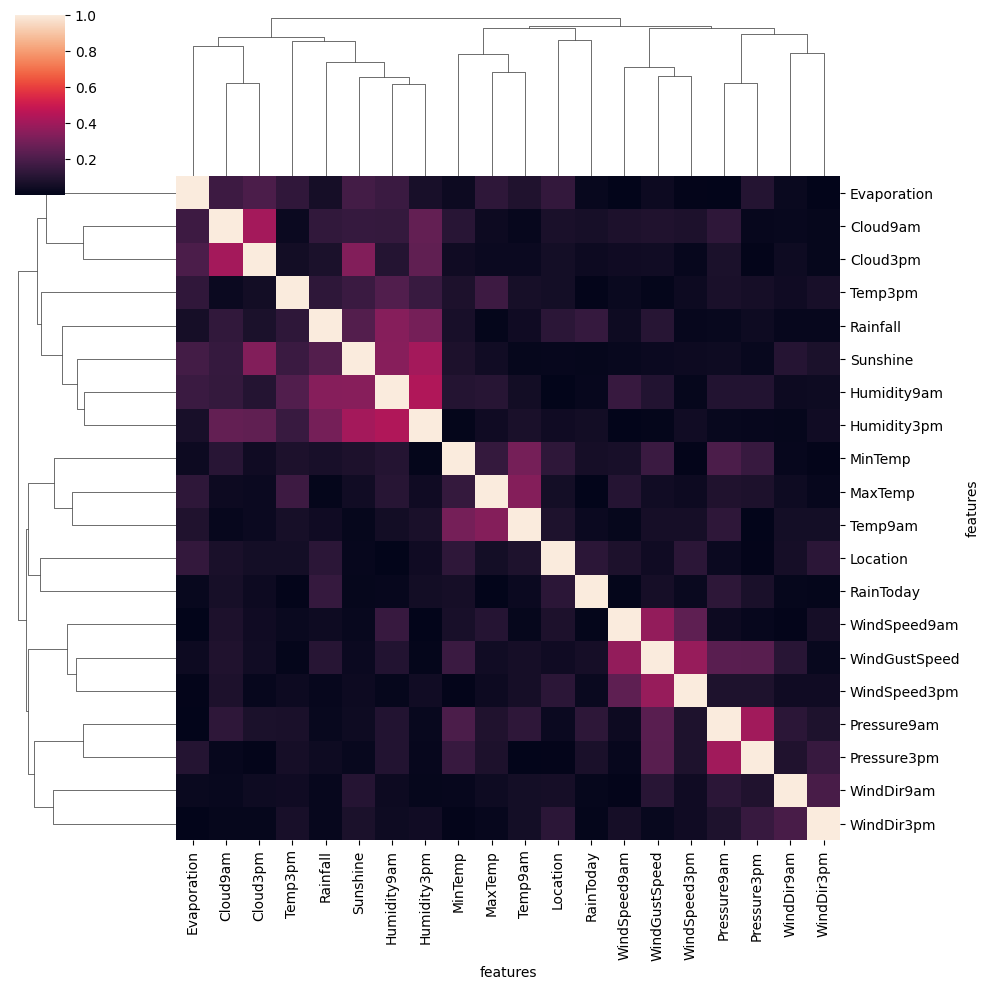

In [101]:
import seaborn as sns
sns.clustermap(shap_df.drop("WindGustDir", axis=1).corr().abs())

## Drop redundant features

In [106]:
unimportant = shap_df.abs().mean()< 0.05
unimportant_feats = unimportant[unimportant.values].index.tolist()

In [118]:
unimportant

features
Location         False
MinTemp           True
MaxTemp           True
Rainfall         False
Evaporation       True
Sunshine         False
WindGustDir       True
WindGustSpeed    False
WindDir9am        True
WindDir3pm       False
WindSpeed9am     False
WindSpeed3pm     False
Humidity9am      False
Humidity3pm      False
Pressure9am      False
Pressure3pm      False
Cloud9am         False
Cloud3pm         False
Temp9am          False
Temp3pm          False
RainToday         True
dtype: bool

<Axes: xlabel='features', ylabel='features'>

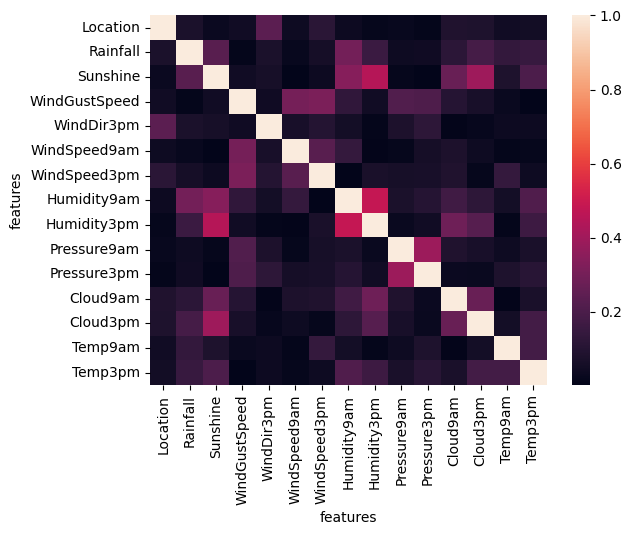

In [119]:
sns.heatmap(shap_df.drop(unimportant_feats, axis=1).corr(method='spearman').abs())

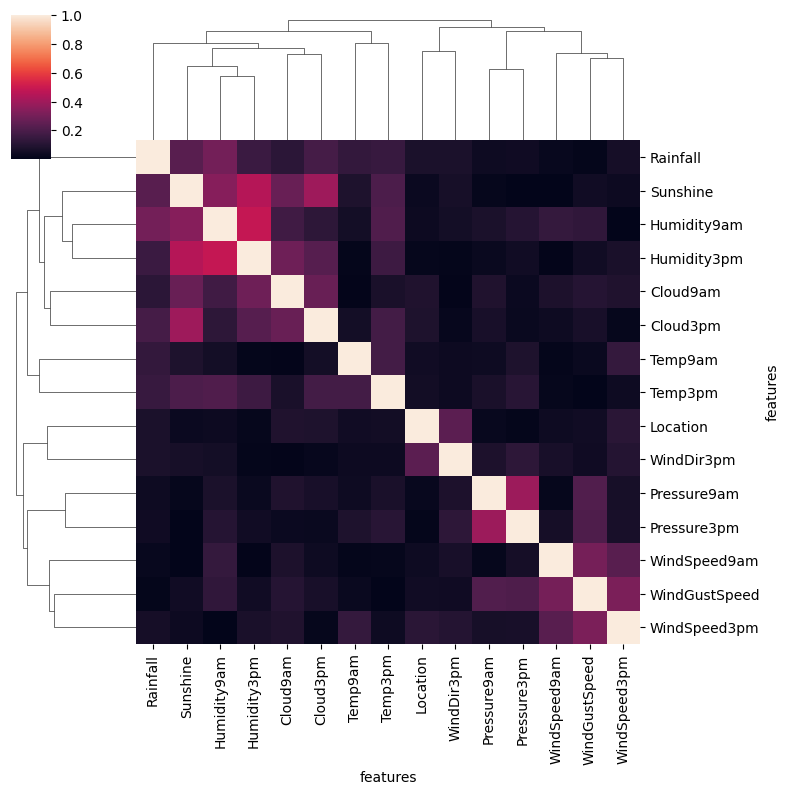

In [121]:
abcorr = shap_df.drop(unimportant_feats, axis=1).corr(method='spearman').abs()
sns.clustermap(abcorr, figsize=(8,8))

In [126]:
abcorr


features,Location,Rainfall,Sunshine,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
features,,,,,,,,,,,,,,,
Location,1.000000,0.074035,0.032107,0.044908,0.235542,0.039342,0.113683,0.033832,0.014255,0.022483,0.010006,0.086731,0.081187,0.044871,0.052115
Rainfall,0.074035,1.000000,0.230309,0.011123,0.074191,0.021538,0.057698,0.297489,0.156189,0.038119,0.042725,0.117956,0.181962,0.134475,0.149522
Sunshine,0.032107,0.230309,1.000000,0.047855,0.060179,0.001649,0.032736,0.337332,0.447127,0.014524,0.001660,0.269361,0.391729,0.081819,0.201082
WindGustSpeed,0.044908,0.011123,0.047855,1.000000,0.041429,0.298269,0.317154,0.128816,0.046696,0.213554,0.206185,0.099870,0.064078,0.026579,0.003288
WindDir3pm,0.235542,0.074191,0.060179,0.041429,1.000000,0.065803,0.095807,0.053422,0.012159,0.079048,0.121985,0.005421,0.017583,0.035539,0.035396
WindSpeed9am,0.039342,0.021538,0.001649,0.298269,0.065803,1.000000,0.231219,0.139598,0.007609,0.013452,0.059407,0.077615,0.036676,0.011486,0.015465
WindSpeed3pm,0.113683,0.057698,0.032736,0.317154,0.095807,0.231219,1.000000,0.001427,0.069662,0.062015,0.064873,0.085115,0.013274,0.139491,0.040016
Humidity9am,0.033832,0.297489,0.337332,0.128816,0.053422,0.139598,0.001427,1.000000,0.484928,0.074299,0.099049,0.169571,0.119143,0.054961,0.211241
Humidity3pm,0.014255,0.156189,0.447127,0.046696,0.012159,0.007609,0.069662,0.484928,1.000000,0.027317,0.044873,0.285094,0.226523,0.010678,0.161832


## Check  correlations of the features with high correlation coef

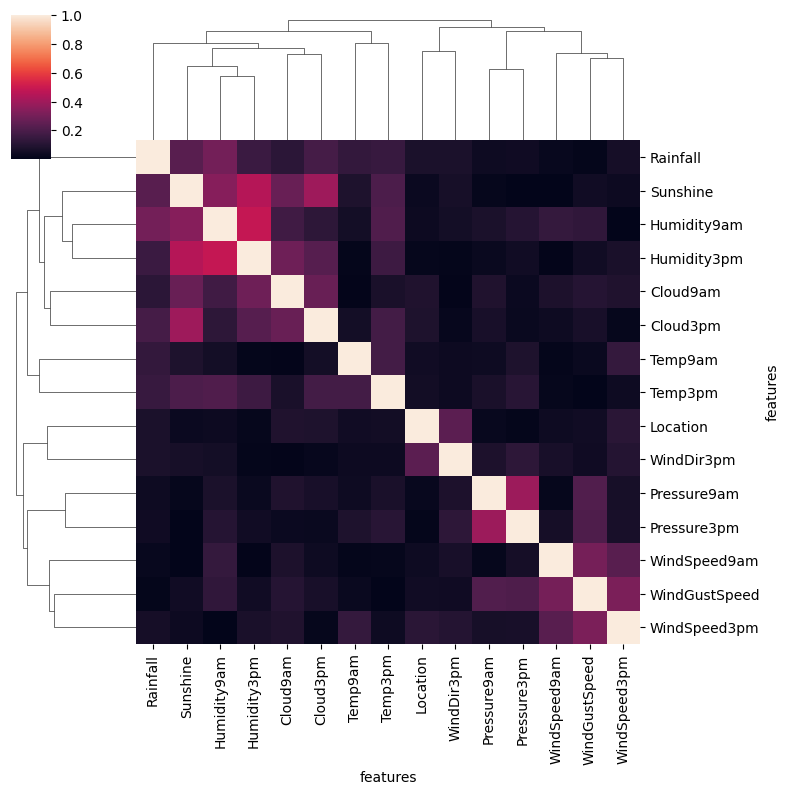

In [132]:
#highestcorrs = (abcorr**2).sum().sort_values()[-5:].index.tolist()
highestcorrs = (abcorr.replace(1, 0)).max().sort_values()[-5:].index.tolist()
sns.clustermap(abcorr.loc[highestcorrs, highestcorrs], figsize=(8,8))

In [133]:
(abcorr.replace(1, 0)).max()

features
Location         0.235542
Rainfall         0.297489
Sunshine         0.447127
WindGustSpeed    0.317154
WindDir3pm       0.235542
WindSpeed9am     0.298269
WindSpeed3pm     0.317154
Humidity9am      0.484928
Humidity3pm      0.484928
Pressure9am      0.388438
Pressure3pm      0.388438
Cloud9am         0.285094
Cloud3pm         0.391729
Temp9am          0.178619
Temp3pm          0.211241
dtype: float64

## Check correlations of the most important features

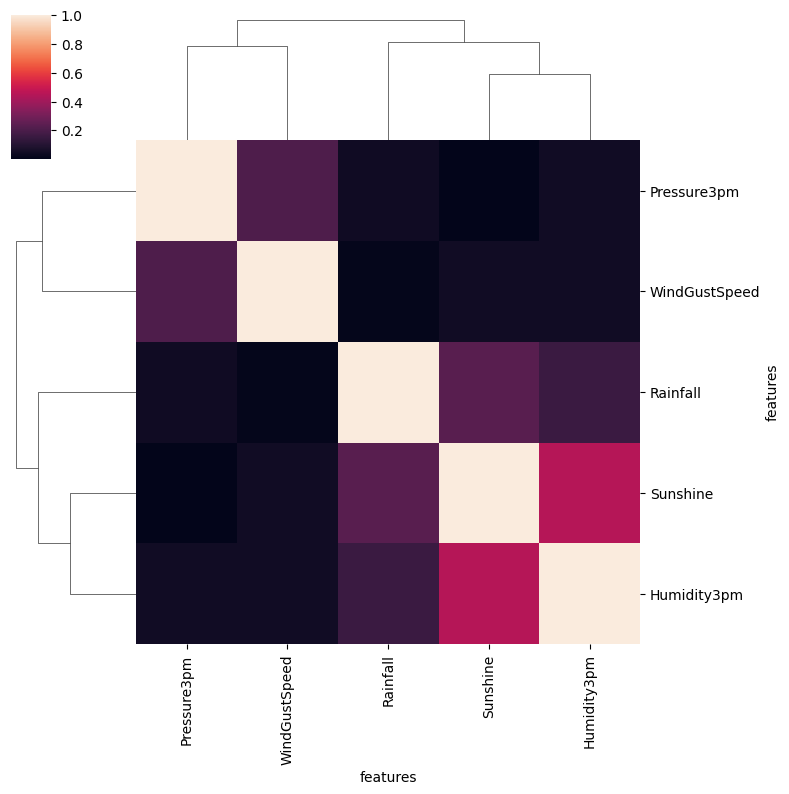

In [125]:
important = shap_df.abs().mean().sort_values()[-5:].index.tolist()
sns.clustermap(abcorr.loc[important, important], figsize=(8,8))